In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras
import scipy.stats as stats
import math
from rate import *

from sklearn.datasets import make_friedman2
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from math import sqrt

from tensorflow.keras.layers import TimeDistributed, Attention, Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, BatchNormalization, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
def plot_means_variances(y_true, y_means, y_stddevs):
    plt.rc('font', size=14)
    min_vals = np.min([np.min(y_true), np.min(y_means)])
    max_vals = np.max([np.max(y_true), np.max(y_means)])

    plt.figure(figsize=(16, 6))

    # Plot predicted vs true
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_means, alpha = .7, color="0.3", linewidth = 0, s = 2)
    plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line
    plt.title('Predicted vs True Values')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    
    def plot_binned_residuals(y_true, residuals, num_bins=20):
        bins = np.linspace(min(y_true), max(y_true), num_bins + 1)

        bin_means = [0]*num_bins
        bin_stddevs = [0]*num_bins

        for i in range(num_bins):
            mask = (y_true >= bins[i]) & (y_true < bins[i + 1])
            if np.any(mask):
                bin_means[i] = np.mean(y_true[mask])
                bin_stddevs[i] = np.sqrt(mean_squared_error(y_means[mask], y_true[mask]))
        return bin_means, bin_stddevs

    bin_means, bin_stddevs = plot_binned_residuals(y_true, y_means, num_bins=20)
    
    # Plot residuals vs true
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_stddevs, alpha = .7, color="0.3", linewidth = 0, s = 2, label='Predicted Standard Deviation', zorder=1)
    plt.scatter(bin_means, bin_stddevs, alpha=1, s=50, color='red', label='True Binned Root Mean Squared Error', zorder=2)
    plt.title('Predicted Standard Deviation vs True RMSE')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Standard Deviation')
    plt.legend()


    plt.tight_layout()
    plt.show()

    
def evaluate_and_print_metrics(results, model_name, y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, ci):
    z_value = stats.norm.ppf((1 + ci) / 2)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_lower_bound = y_train_pred - z_value * y_train_stddevs
    train_upper_bound = y_train_pred + z_value * y_train_stddevs

    test_lower_bound = y_test_pred - z_value * y_test_stddevs
    test_upper_bound = y_test_pred + z_value * y_test_stddevs

    train_within_interval = np.sum(np.logical_and(y_train.ravel() >= train_lower_bound, y_train.ravel() <= train_upper_bound))
    test_within_interval = np.sum(np.logical_and(y_test.ravel() >= test_lower_bound, y_test.ravel() <= test_upper_bound))

    train_percentage_within_interval = (train_within_interval / len(y_train.ravel())) * 100
    test_percentage_within_interval = (test_within_interval / len(y_test.ravel())) * 100

   
    results[model_name] = {
        "Test Root Mean Squared Error (RMSE): ": test_rmse,
        "Test Mean Absolute Error (MEA): ": test_mae,
        f"Percentage of Test Data Points within {ci:.2f}% CI: ": test_percentage_within_interval
    }

    print(f"Train RMSE: {train_rmse:.3f}")
    print(f"Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}")
    print(f"Test MAE: {test_mae:.3f}")
    print(f"Percentage of Train Data Points within {ci*100:.2f}% CI: {train_percentage_within_interval:.2f}%")
    print(f"Percentage of Test Data Points within {ci*100:.2f}% CI: {test_percentage_within_interval:.2f}%")

def plot_confidence_interval_histogram(y_test_pred, y_test_std, y_test, bins=20):
    plt.rc('font', size=14)
    
    # Compute the t-values of the confidence intervals based on Z-scores
    t_values = np.array([norm.ppf(i/bins + (1-i/bins)/2) for i in range(1, bins+1)])

    percentages_within_interval = []
    for t_value in t_values:
        lower_bounds = y_test_pred.ravel() - t_value * y_test_std
        upper_bounds = y_test_pred.ravel() + t_value * y_test_std

        # Count number of data points within the confidence interval
        is_within_interval = np.logical_and(y_test >= lower_bounds, y_test <= upper_bounds)
        num_within_interval = np.sum(is_within_interval)

        # Calculate the percentage of data points within the confidence interval
        percentage_within_interval = (num_within_interval / len(y_test)) * 100
        percentages_within_interval.append(percentage_within_interval)

    plt.figure(figsize=(16, 6))
    bars = plt.bar(np.arange(1, bins+1), percentages_within_interval, color='lightgray', edgecolor='black')
    plt.xlabel('Confidence Intervals')
    plt.ylabel('Percentage within Interval')
    plt.title('Percentage of Data Points within Confidence Intervals')

    # Add numbers on top of interval bar
    for bar, percentage in zip(bars, percentages_within_interval):
        plt.text(bar.get_x() + bar.get_width() / 8,
             bar.get_height() + 1,
             f'{percentage:.1f}%', 
             fontsize=9)

    plt.xticks(np.arange(1, bins+1), [f'{i/bins*100:.0f}%' for i in range(1, bins+1)])
    plt.savefig("bar2.png", bbox_inches='tight')
    plt.show()
    
def train_model(model, X_train, y_train, patience, epochs, batch_size, cp_callback):
    tf.random.set_seed(MODELS_SEED)
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model.summary()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.1, callbacks=[early_stopping, cp_callback])
    return history

def load_dataset_train_test_split(df, features, output_feature):
    X = df[features]
    y = df[output_feature]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

    # Scale input data to facilitate training
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, np.array(y_train), np.array(y_test), scaler

def NLL(y, distr): 
    return -distr.log_prob(y) 

# We add 0.001 to the standard deviation to ensure it does not converge to 0 and destabilizes training because the gradient
# of maximum likelihood estimation requires the inversion of the variance. We also activate the parameters using a softplus
# activation function to enfore a positive standard deviation estimate.
def normal_softplus(params): 
    return tfd.Normal(loc=params[:, 0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:, 1:2]))

def multivariate_covariance_normal_softplus(mean_params, std_params, d): 
    means = mean_params
    stds = 1e-3 + tf.math.softplus(0.05 * std_params)
    
    return tfd.MultivariateNormalTriL(loc=means, scale_tril=tfp.math.fill_triangular(stds))

def multivariate_diagonal_normal_softplus(mean_params, std_params, d): 
    means = mean_params
    stds = 1e-3 + tf.math.softplus(0.05 * std_params)
    
    return tfd.MultivariateNormalDiag(loc=means, scale_diag=stds)

In [7]:
def create_model_mlp_gaussian_joint(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = Dense(100, activation="relu")(inputs)
    hidden2 = Dense(80, activation="relu")(hidden1)
    hidden3 = Dense(40, activation="relu")(hidden2)
    
    mean_h1 = Dense(20, activation="relu")(hidden3)
    mean_out = Dense(1)(mean_h1)
    
    variance_h1 = Dense(20, activation="relu")(hidden3)
    variance_out = Dense(1)(variance_h1)
    
    params = Dense(2)(Concatenate()([mean_out, variance_out]))

    
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_mlp_gaussian = Model(inputs=inputs, outputs=dist)
    model_mlp_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_mlp_gaussian

In [8]:
# In order to ensure that each model has repeatable results,we fix the seed both for the
# data splitting part and for the initilialization of the networks' weights. Theoretially
# speaking, we should average over different seeds to ensure the robustness of our results.
# However, in practice, due to the size of the data set this is unfeasibile and we only do
# this for the best performing model to show that the variability of results based on seed
# is almost none.

keras.utils.set_random_seed(812)
MODELS_SEED = 42

In [9]:
file_path = 'Cleaned_data.pkl'
df_full = pd.read_pickle(file_path)

Total data points for turbine 5 before removing NaNs:  191579
Total data points for turbine 5 after removing NaNs:  189381
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 100)                  3600      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 80)                   8080      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 40)                   3240      ['

4262/4262 [==============================] - 11s 3ms/step - loss: 3.7805 - val_loss: 3.7805
Epoch 50/100
4262/4262 [==============================] - 11s 3ms/step - loss: 3.7791 - val_loss: 3.8642
Epoch 51/100
4262/4262 [==============================] - 11s 3ms/step - loss: 3.7777 - val_loss: 3.7667
Epoch 52/100
4262/4262 [==============================] - 11s 3ms/step - loss: 3.7663 - val_loss: 3.8365
Epoch 53/100
4262/4262 [==============================] - 12s 3ms/step - loss: 3.7676 - val_loss: 3.8190
Epoch 54/100
4262/4262 [==============================] - 11s 3ms/step - loss: 3.7649 - val_loss: 3.8055
Epoch 55/100
4262/4262 [==============================] - 12s 3ms/step - loss: 3.7659 - val_loss: 3.8160
Epoch 56/100
4262/4262 [==============================] - 12s 3ms/step - loss: 3.7586 - val_loss: 4.2440
Epoch 57/100
4262/4262 [==============================] - 11s 3ms/step - loss: 3.7604 - val_loss: 3.8294
Epoch 58/100
4262/4262 [==============================] - 11s 3ms/st

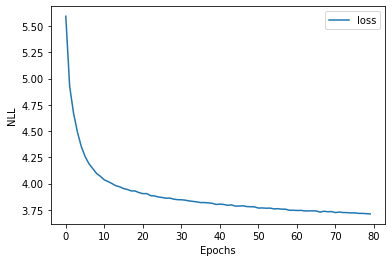

Train RMSE: 26.169
Test RMSE: 26.890
Train MAE: 14.254
Test MAE: 14.578
Percentage of Train Data Points within 99.00% CI: 99.14%
Percentage of Test Data Points within 99.00% CI: 98.89%


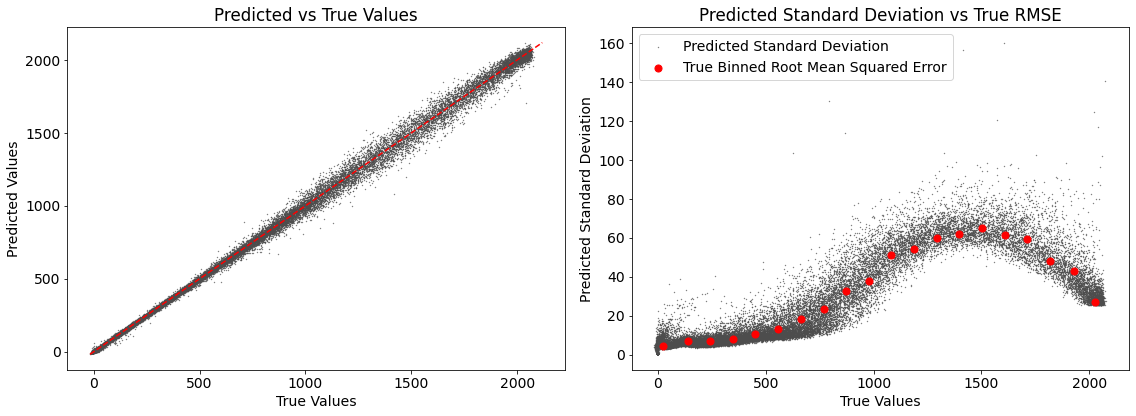

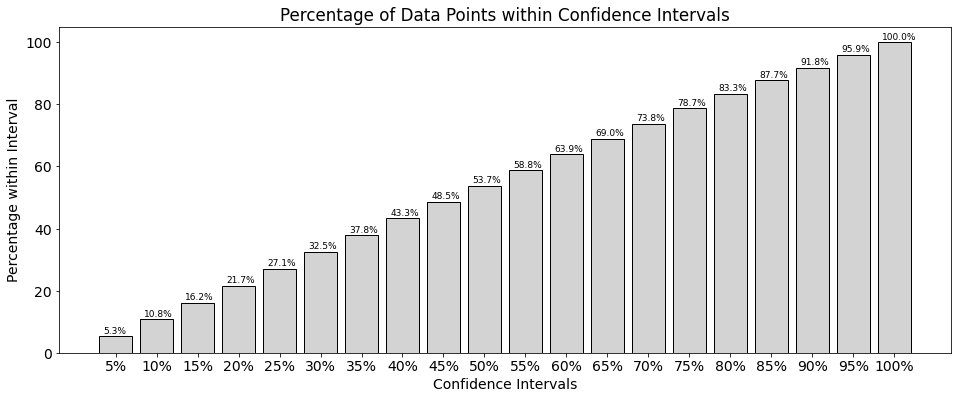

In [12]:
# Set confidence interval to be considered as 'normal behaviour'
CONFIDENCE_INTERVAL = 0.99

# Datetime column
DATETIME_COL = 'Date.time'

# Features considered
features = [
    [
    'Wind.speed.me',
    'Wind.speed.sd',
    'Wind.speed.min',
    'Wind.speed.max',
    'Front.bearing.temp.me',
    'Front.bearing.temp.sd',
    'Front.bearing.temp.min',
    'Front.bearing.temp.max',
    'Rear.bearing.temp.me',
    'Rear.bearing.temp.sd',
    'Rear.bearing.temp.min',
    'Rear.bearing.temp.max',
    'Rotor.bearing.temp.me',
    'Stator1.temp.me',
    'Nacelle.ambient.temp.me',
    'Nacelle.temp.me',
    'Transformer.temp.me',
    'Gear.oil.temp.me',
    'Gear.oil.temp.me.1',
    'Top.box.temp.me',
    'Hub.temp.me',
    'Conv.Amb.temp.me',
    'Rotor.bearing.temp.me',
    'Transformer.cell.temp.me',
    'Motor.axis1.temp.me',
    'Motor.axis2.temp.me',
    'CPU.temp.me',
    'Blade.ang.pitch.pos.A.me',
    'Blade.ang.pitch.pos.B.me',
    'Blade.ang.pitch.pos.C.me',
    'Gear.oil.inlet.press.me',
    'Gear.oil.pump.press.me',
    'Drive.train.acceleration.me',
    'Tower.Acceleration.x',
    'Tower.Acceleration.y'
    ]
]

output_features = [
    'Power.me'
]

results = {}

for i in range(len(output_features)):
    
    features, output_feature = features[i], output_features[i]

    # Only consider the turbine with ID 5
    TURBINE_ID = 5
    df = df_full[df_full['turbine'] == TURBINE_ID]
    print(f"Total data points for turbine {TURBINE_ID} before removing NaNs: ", len(df))
    df = df.dropna(subset=features + [output_feature] + [DATETIME_COL])
    print(f"Total data points for turbine {TURBINE_ID} after removing NaNs: ", len(df))
    df = df.reset_index(drop=False) 

    X_train, X_test, y_train, y_test, scaler = load_dataset_train_test_split(df, features, output_feature)

    model_file_path = f"saved_models/model_mlp_gaussian_joint_{output_feature}.keras"

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_file_path,
                                                     save_weights_only=True,
                                                     verbose=0)
                                      
    model_mlp_gaussian_joint = create_model_mlp_gaussian_joint(X_train, MODELS_SEED)

    history = train_model(model_mlp_gaussian_joint,
                          X_train, y_train,
                          patience=15, epochs=100, batch_size=32,
                          cp_callback=cp_callback)

    model_mlp_gaussian_joint.load_weights(model_file_path)
    model_mlp_gaussian_joint.evaluate(X_test, y_test)
                                      
    # Plot loss history
    plt.plot(history.history['loss'][1:])
    plt.legend(['loss'])
    plt.ylabel('NLL')
    plt.xlabel('Epochs')
    plt.show()
                                      
    y_train_pred = np.array(model_mlp_gaussian_joint(X_train).mean()).ravel()
    y_test_pred = np.array(model_mlp_gaussian_joint(X_test).mean()).ravel()

    y_train_stddevs = np.array(model_mlp_gaussian_joint(X_train).stddev()).ravel()
    y_test_stddevs = np.array(model_mlp_gaussian_joint(X_test).stddev()).ravel()

    evaluate_and_print_metrics(results, f"Non-Bayesian MLP with Gaussian Output (Joint Sub-models) - {output_feature}",
    y_train, y_test, y_train_pred, y_test_pred,
    y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

    plot_means_variances(y_test, y_test_pred, y_test_stddevs)
    plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test, bins=20)

In [14]:
# Print metric results for all trained models
for model_name, res in results.items():
    print("Model: ", model_name)
    for metric, value in res.items():
        print(f"{metric:50} {value}")
    print("\n")

Model:  Non-Bayesian MLP with Gaussian Output (Joint Sub-models) - Power.me
Test Root Mean Squared Error (RMSE):               26.890055097382607
Test Mean Absolute Error (MEA):                    14.577795856687294
Percentage of Test Data Points within 0.99% CI:    98.88850753755577


